# Amex 1st Place Pipeline - Step 3: Training & Inference (v5)

This notebook trains and evaluates the model using the **preprocessed data** created by `v5_LGBM_Preprocessing.ipynb`.

1.  Loads `train_processed.parquet`.
2.  Loads the saved `column_lists.json`.
3.  Trains the full 3-seed, 5-fold (15-model) LightGBM DART ensemble on the GPU.
4.  Saves the models and plots performance.
5.  Deletes train data from RAM.
6.  Loads `test_processed.parquet`.
7.  Runs inference and creates `submission_v5_blend.csv`.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import json
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

# Import the official metric from amex_metric.py
from amex_metric import amex_metric

print(f"LightGBM version: {lgb.__version__}")
sns.set_style('whitegrid')

# --- Define Paths ---
FE_DATA_DIR = '../data_fe/'
CSV_DATA_DIR = '../data/'
MODEL_DIR = './models/'
PREPROCESSOR_DIR = './preprocessors/'

TRAIN_PATH = os.path.join(FE_DATA_DIR, 'train_processed.parquet')
TEST_PATH = os.path.join(FE_DATA_DIR, 'test_processed.parquet') 
SUB_PATH = os.path.join(CSV_DATA_DIR, 'sample_submission.csv')

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

LightGBM version: 4.6.0


c:\Users\user\OneDrive - Nanyang Technological University\NTU School Work\Year 3 S1\SC4000\Project\amex-default-prediction-project-code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Metric Wrapper & Seed Function

In [2]:
def amex_metric_lgbm(y_pred, y_true):
    y_true_labels = y_true.get_label()
    dummy_index = range(len(y_true_labels))
    y_true_df = pd.DataFrame({'target': y_true_labels}, index=dummy_index)
    y_pred_df = pd.DataFrame({'prediction': y_pred}, index=dummy_index)
    y_true_df.index.name = 'customer_ID'
    y_pred_df.index.name = 'customer_ID'
    return 'amex_metric', amex_metric(y_true_df, y_pred_df), True

print("amex_metric_lgbm wrapper defined.")

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

print("seed_everything function defined.")

amex_metric_lgbm wrapper defined.
seed_everything function defined.


## Step 2: Load Processed Train Data

In [3]:
print(f"Loading PROCESSED train features from {TRAIN_PATH}...")
start_time = time.time()
train_df = pd.read_parquet(TRAIN_PATH)
print(f"Processed train data loaded in {time.time() - start_time:.2f}s. Shape: {train_df.shape}")

# --- Separate X and y ---
y_train = train_df['target']
X_train = train_df.drop(columns=['target'])
del train_df; gc.collect()
print("Separated y_train and X_train.")

# --- Load column lists ---
print("Loading column lists...")
with open(os.path.join(PREPROCESSOR_DIR, 'column_lists.json'), 'r') as f:
    column_lists = json.load(f)

features = column_lists['all_features']
categorical_cols = [col for col in column_lists['categorical_cols_for_lgb'] if col in features]

print(f"Features ({len(features)}) and categorical features ({len(categorical_cols)}) loaded.")
gc.collect()

Loading PROCESSED train features from ../data_fe/train_processed.parquet...
Processed train data loaded in 12.90s. Shape: (458913, 7007)
Separated y_train and X_train.
Loading column lists...
Features (7005) and categorical features (99) loaded.


0

## Step 3: Train Model (Seed Blending with 1st Place Params)

This cell trains all 15 models and saves them to the `./models/` directory.

In [4]:
print("Starting 3-Seed DART Model Training...")

# --- LightGBM Parameters (from 1st Place S5_LGB_main.py) ---
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss', 
    'boosting': 'dart',
    'max_depth': -1,
    'num_leaves': 64,
    'learning_rate': 0.035,
    'bagging_freq': 5,
    'bagging_fraction': 0.75,
    'feature_fraction': 0.05,
    'min_data_in_leaf': 256,
    'max_bin': 63,
    'min_data_in_bin': 256,
    'tree_learner': 'serial',
    'boost_from_average': 'false',
    'lambda_l1': 0.1,
    'lambda_l2': 30,
    'num_threads': -1,
    'verbosity': 1,
    # --- GPU Parameters --- (Set to 1 to select NVIDIA)
    'device': 'gpu', 
    'gpu_platform_id': 1,  
    'gpu_device_id': 0
}

# --- Setup CV --- 
N_SPLITS = 5
SEEDS = [42, 52, 62] # Seed blending
NUM_BOOST_ROUND = 4500 # Use 4500 for final, or 100 for a quick test

print(f"Training with {len(features)} features.")
print(f"Found {len(categorical_cols)} categorical features for LightGBM.")

# --- Arrays to store blended predictions ---
oof_predictions_all_seeds = []
models_seed_42 = [] 
fold_evals_results_seed_42 = [] 

X_train_lgb = X_train[features]

for seed in SEEDS:
    print(f"\n{'='*50}")
    print(f"--- TRAINING WITH SEED {seed} ---")
    print(f"{'='*50}")
    
    seed_everything(seed)
    lgb_params['seed'] = seed
    
    oof_predictions_seed = np.zeros(X_train.shape[0])

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
    
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_lgb, y_train)):
        fold_start_time = time.time()
        print(f"\n--- Fold {fold+1}/{N_SPLITS} (Seed {seed}) ---")
        
        X_train_fold, X_val_fold = X_train_lgb.iloc[train_index], X_train_lgb.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        lgb_train = lgb.Dataset(X_train_fold, y_train_fold, categorical_feature = categorical_cols)
        lgb_valid = lgb.Dataset(X_val_fold, y_val_fold, categorical_feature = categorical_cols)
        
        # Create the dictionary to store results
        evals_result_dic = {} 
        
        model = lgb.train(
            params = lgb_params,
            train_set = lgb_train,
            num_boost_round = NUM_BOOST_ROUND, 
            valid_sets = [lgb_valid], 
            callbacks=[
                lgb.log_evaluation(period=100), # Log every 100 rounds
                lgb.record_evaluation(evals_result_dic) 
            ], 
            feval = amex_metric_lgbm
            )
        
        model.best_iteration = NUM_BOOST_ROUND 

        val_preds = model.predict(X_val_fold)
        oof_predictions_seed[val_index] = val_preds
        
        # --- Save the model to disk --- 
        model_path = os.path.join(MODEL_DIR, f'model_seed_{seed}_fold_{fold}.txt')
        model.save_model(model_path)
        print(f"Model for fold {fold+1} saved to {model_path}")
        
        if seed == SEEDS[0]:
            models_seed_42.append(model)
            fold_evals_results_seed_42.append(evals_result_dic)
        
        print(f"Fold {fold+1} complete in {time.time() - fold_start_time:.2f}s")
        del X_train_fold, X_val_fold, y_train_fold, y_val_fold, lgb_train, lgb_valid, model, evals_result_dic
        gc.collect()

    oof_df_seed = pd.DataFrame({'customer_ID': X_train['customer_ID'], 'target': y_train, 'prediction': oof_predictions_seed})
    oof_score_seed = amex_metric(oof_df_seed[['customer_ID', 'target']], oof_df_seed[['customer_ID', 'prediction']])
    print(f"\n--- OOF Score for Seed {seed}: {oof_score_seed:.6f} ---")
    
    oof_predictions_all_seeds.append(oof_predictions_seed)
    gc.collect()

print(f"\n--- Training Complete ---,")

# --- Calculate Final Blended OOF Score ---
oof_predictions = np.mean(oof_predictions_all_seeds, axis=0)
oof_df = pd.DataFrame({'customer_ID': X_train['customer_ID'], 'target': y_train, 'prediction': oof_predictions})
oof_score = amex_metric(oof_df[['customer_ID', 'target']], oof_df[['customer_ID', 'prediction']])

print(f"\n{'='*51}")
print(f"  Final Blended CV (OOF) Amex Score: {oof_score:.6f}")
print(f"{'='*51}")

# --- FREE UP MEMORY ---
print("Deleting X_train, y_train, and OOF data to free memory...")
del X_train_lgb, X_train, y_train, oof_predictions, oof_df, oof_df_seed, oof_predictions_all_seeds, oof_predictions_seed
gc.collect()

Starting 3-Seed DART Model Training...
Training with 7005 features.
Found 99 categorical features for LightGBM.

--- TRAINING WITH SEED 42 ---

--- Fold 1/5 (Seed 42) ---
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 247894
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 6814
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2753 dense feature groups (964.94 MB) transferred to GPU in 0.301972 secs. 1 sparse feature groups
[100]	valid_0's binary_logloss: 0.338176	valid_0's amex_metric: 0.764611
[200]	valid_0's binary_logloss: 0.300869	valid_0's amex_metric: 0.768919
[30

0

## Step 4: Analyze Model Performance (Seed 42)

Plots from the first seed's training run.

--- Plotting Learning Curves (Seed 42) ---


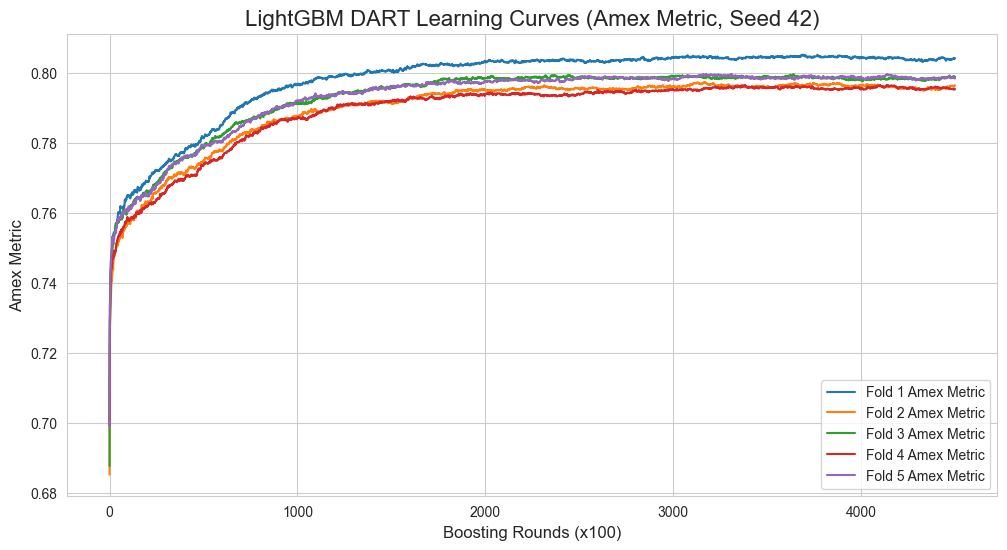


--- Analyzing Feature Importance (Seed 42) ---
Top 40 Most Important Features (by 'gain', Seed 42):
              feature     importance
4675   last6_P_2_last  442566.079819
2338    last3_P_2_max  413893.381338
2340   last3_P_2_last  399637.519822
4672    last6_P_2_min  390815.360474
5            P_2_last  358359.989679
2339    last3_P_2_sum  354216.098572
2335   last3_P_2_mean  298500.123586
2337    last3_P_2_min  233237.632392
2             P_2_min  213022.061849
0            P_2_mean  210065.469559
4674    last6_P_2_sum  178920.838472
4670   last6_P_2_mean  172767.025767
2442  last3_D_48_last  160710.538150
4673    last6_P_2_max  159884.775362
2484   last3_B_9_last  157229.489197
4             P_2_sum  147750.256223
4819   last6_B_9_last  141105.731593
65          D_44_last  120579.219179
149          B_9_last  119162.841186
2358   last3_B_2_last  107970.134320
4777  last6_D_48_last  107635.003505
2437  last3_D_48_mean  106024.696517
2482    last3_B_9_max   92011.551784
2352   last

C:\Users\user\AppData\Local\Temp\ipykernel_10824\2246567686.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


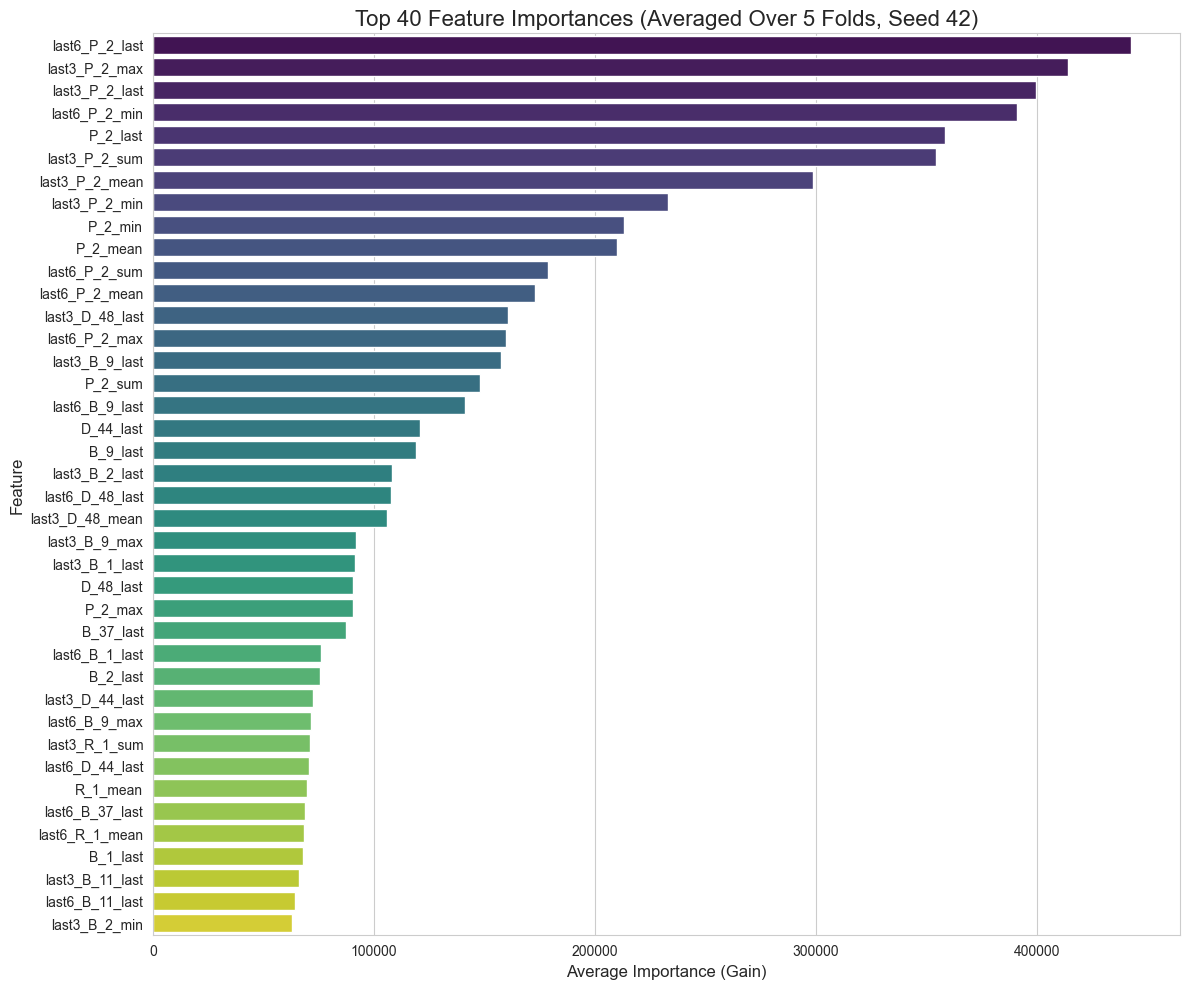

In [6]:
print("--- Plotting Learning Curves (Seed 42) ---")

plt.figure(figsize=(12, 6))
for fold, results in enumerate(fold_evals_results_seed_42):
    # --- KEYERROR FIX: Use 'valid_0' --- 
    if 'valid_0' in results and 'amex_metric' in results['valid_0']:
        metric_values = results['valid_0']['amex_metric']
        plt.plot(metric_values, label=f'Fold {fold+1} Amex Metric')
    else:
        print(f"Warning: 'valid_0' or 'amex_metric' not found in results for fold {fold+1}")

plt.title('LightGBM DART Learning Curves (Amex Metric, Seed 42)', fontsize=16)
plt.xlabel('Boosting Rounds (x100)', fontsize=12) # Updated label as we log every 100 rounds
plt.ylabel('Amex Metric', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Analyzing Feature Importance (Seed 42) ---")

feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = features
feature_importance_df['importance'] = 0

for fold, model in enumerate(models_seed_42):
    feature_importance_df['importance'] += model.feature_importance(importance_type='gain') / N_SPLITS

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(f"Top 40 Most Important Features (by 'gain', Seed 42):")
print(feature_importance_df.head(40).to_string())

plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(40),
    palette='viridis'
)
plt.title('Top 40 Feature Importances (Averaged Over 5 Folds, Seed 42)', fontsize=16)
plt.xlabel('Average Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## Step 5: Load and Run Inference on Test Data

In [7]:
print(f"Loading PROCESSED test features from {TEST_PATH}...")
start_time = time.time()
X_test = pd.read_parquet(TEST_PATH)
print(f"Processed test data loaded in {time.time() - start_time:.2f}s. Shape: {X_test.shape}")
gc.collect()

print("Starting Inference on Test Set...")
start_time = time.time()

# Ensure 'features' list matches what was used in training
X_test_lgb = X_test[features]
test_predictions_all_seeds = []

for seed in SEEDS:
    print(f"Predicting with models from SEED {seed}...")
    test_preds_seed = np.zeros(X_test_lgb.shape[0])
    
    for fold in range(N_SPLITS):
        print(f"  Loading and predicting with Fold {fold+1} model...")
        model_path = os.path.join(MODEL_DIR, f'model_seed_{seed}_fold_{fold}.txt')
        model = lgb.Booster(model_file=model_path)
        test_preds_seed += model.predict(X_test_lgb) / N_SPLITS
    
    test_predictions_all_seeds.append(test_preds_seed)
    gc.collect()

# Blend the predictions from all seeds
test_predictions = np.mean(test_predictions_all_seeds, axis=0)

print(f"Inference complete in {time.time() - start_time:.2f}s")

del X_test_lgb, test_preds_seed, test_predictions_all_seeds, model
gc.collect()

Loading PROCESSED test features from ../data_fe/test_processed.parquet...
Processed test data loaded in 51.80s. Shape: (924621, 7006)
Starting Inference on Test Set...
Predicting with models from SEED 42...
  Loading and predicting with Fold 1 model...
  Loading and predicting with Fold 2 model...
  Loading and predicting with Fold 3 model...
  Loading and predicting with Fold 4 model...
  Loading and predicting with Fold 5 model...
Predicting with models from SEED 52...
  Loading and predicting with Fold 1 model...
  Loading and predicting with Fold 2 model...
  Loading and predicting with Fold 3 model...
  Loading and predicting with Fold 4 model...
  Loading and predicting with Fold 5 model...
Predicting with models from SEED 62...
  Loading and predicting with Fold 1 model...
  Loading and predicting with Fold 2 model...
  Loading and predicting with Fold 3 model...
  Loading and predicting with Fold 4 model...
  Loading and predicting with Fold 5 model...
Inference complete in 769

0

## Step 6: Create Submission File

This creates `submission_v5_blend.csv` using the final blended predictions.

In [10]:
print("Creating submission file...")

submission_df = pd.DataFrame({
    'customer_ID': X_test['customer_ID'],
    'prediction': test_predictions
})

sample_sub_df = pd.read_csv(SUB_PATH)
submission_df = sample_sub_df[['customer_ID']].merge(submission_df, on='customer_ID', how='left')
submission_df['prediction'] = submission_df['prediction'].fillna(0.0)

submission_path = 'submission_v5_blend.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")
print("File head:")
print(submission_df.head())

del X_test, submission_df, sample_sub_df
gc.collect()

Creating submission file...


NameError: name 'X_test' is not defined

I got 
Public Score: 0.79971
Private score: 0.80827
Which is about about Top 25%